# WDL 2021 Final - Improving the quality of life by reducing city noise levels

## Authors

Ana Almeida &
Bruno Silva &
Carolina Alves &
Fábio Santos

## External links and resources

INCLUIR AQUI ...

# Introduction

Over the last years, the quality of life of urban population has received considerable attention from social scientists. [1] One of the aspects of quality of life is related to health, which according to the World Health Organization (WHO) is defined as “A state of physical, mental and social well-being, not merely the absence of disease and infirmity”. [2]

Related to the health of urban population are the different types of urban pollution. Environmental noise, due to the growing number of people in cities, starts to achieve high noise levels and, as consequence, to have a negative impact on people’s lives. 

The prolonged exposure to environmental noise is associated with an increased risk of negative physical and psychological health outcomes. [3] Besides that, environmental noise is highly related to sleep disturbances in urban areas, causing immediate effects, like trouble in falling asleep, next-day effects, like irritability, and also long-term effects on mental and cardiovascular health. [4] During the day it is recommended that noise levels are kept below 65 dB, which is the measure that the WHO defined as the noise pollution threshold, and during the night, for a person to have a restful sleep, the level must drop below 30 dB. [5]

According to literature, the main sources of environmental noise are road traffic, air traffic, industry, construction and nightlife. [3][5] Some of the studies carried out in this area encompass the use of sensors to monitor sound levels and also make use of other types of variables such as traffic factors, meteorological factors, number of people, city events, and special places such as pubs, restaurants and big squares. [1][6][7]

With this work, we intend to detect and predict high noise levels as we believe that this is one of the approaches that allows the elaboration of measures to combat noise pollution. Furthermore, with the various types of data provided, we intend to understand how noise levels vary throughout the day, week, month, and year, and also how they relate to other types of data such as the number of people, demographical characteristics, weather, holidays, weekends, and soccer games.

**Análise mapas**

With the previous analysis, it was possible to determine the model in terms of which variables to use and the type of the outcome. Our solution **Adicionar aqui o texto do modelo**

**Quais os anos de dados**

**Referência dos jogos de futebol**

# Data pre-processing

The data provided are for several years but, for this work, only data from the years 2016, 2017, 2018, and 2019 are used. We considered that the years of 2020 and 2021, due to COVID-19, may have notable differences when comparing to the others and, therefore, their analysis would have to be separate. To optimize the time, we did not analyze them.

In section 3.3, in order to avoid the repetition of reading the files, the dataset of selected years was previously saved in binary format to make the process faster. Thus, the function saving_dfs_as_binary_files can be passed.

## Import libraries and customize seaborn

In [1]:
import pandas as pd
import numpy as np
import math
import time
import datetime
import pickle
#import requestsz
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
#from math import floor, sin, cos, sqrt, atan2, radians, asin
#from keras.layers import Dense, Dropout, Flatten
#from keras.layers.convolutional import Conv1D, MaxPooling1D
#from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
#import folium
from itertools import combinations
#import networkx as nx

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

pd.set_option('display.max_rows', 100)
sns.set_theme(style="whitegrid")
fig_dim = (16,9)

from pylab import rcParams
rcParams['figure.figsize'] = 20, 12

import warnings
warnings.filterwarnings('ignore')

base = 'Data/noise_data/csv_format'
base_carol = r'C:\Users\Carolina Alves\Desktop\WDL competition\ChildrenOfJupyter\Final\Data\sim_count'

## Auxiliar functions

In [2]:
# bar plot function
def bar_plot(_x, _y, _data):
    fig, axs = plt.subplots(figsize=fig_dim)
    axs = sns.barplot(x=_x, y=_y, data=_data)
    plt.xticks(rotation=90)
    plt.draw()
    
# performs the encoding of categorical features to ordinal numbers
def encode_categorical_features(_df, features):
    df = _df.copy()
    enc = OrdinalEncoder()
    df[features] = enc.fit_transform(df[features]).astype(int)
    
    return enc, df

def correlation_matrix (df, fig_dim):
    cor = df.corr()
    mask = np.triu(np.ones_like(cor, dtype=bool))
    fig,ax = plt.subplots(figsize=fig_dim)
    sns.heatmap(cor, mask=mask, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

## Loading the dataset

In [3]:
# Opening and saving the original dataset
# We converted the file from csv to binary in order to read it faster
# You do not need to run this cell
def saving_dfs_as_binary_files(base):
    
    df = pd.read_csv(base+'/'+"san_salvario_" + str(2016) + ".csv", sep=";")
    
    for year in range(2017, 2020):
        _df_year = pd.read_csv(base+'/'+"san_salvario_" + str(year) + ".csv", sep=";")
        df = pd.concat([df, _df_year])
    
    pickle.dump(df, open(base+'/'+"df_raw", "wb"))
        
saving_dfs_as_binary_files(base)

In [4]:
sensors = ['C1', 'C2', 'C3', 'C4', 'C5']

# Opening data
def get_sensors_data(sensors):
    df = pickle.load(open(base+'/'+"df_raw", "rb" ))

    for col in sensors:
        df[col] = df[col].str.replace(',', '.').astype(float)

    df['date'] = pd.to_datetime(df["Data"] + df['Ora'] , format='%d-%m-%Y%H:00')
    df['year'] = df["date"].dt.year
    df['month'] = df["date"].dt.month
    df['day'] = df["date"].dt.day
    df['hour'] = df['Ora'].str.replace(':00', '').astype(int)
    
    df = df.set_index('date')

    # get average of noise levels
    temp = ['C1_temp', 'C2_temp', 'C3_temp', 'C4_temp', 'C5_temp']
    for i in range(len(sensors)):
        df[temp[i]] = pow(10, df[sensors[i]]/10)

    df['C_avg'] = df[temp].sum(axis = 1)\
        .div(5 - df[temp].isnull().sum(axis=1))
    df['C_avg'] = 10*np.log10(df['C_avg'])
    
    #return df
    return df[['year', 'month', 'day', 'hour', 'C1', 'C2', 'C3', 'C4', 'C5', 'C_avg']]
    
df = get_sensors_data(sensors)
df

,year,month,day,hour,C1,C2,C3,C4,C5,C_avg
date,,,,,,,,,,
2016-06-01 00:00:00,2016,6,1,0,61.1,58.8,63.7,60.4,60.2,61.162532
2016-06-01 01:00:00,2016,6,1,1,57.2,56.1,60.4,57.7,58.4,58.207715
2016-06-01 02:00:00,2016,6,1,2,52.5,53.4,52.9,56.7,56.5,54.788571
2016-06-01 03:00:00,2016,6,1,3,50.6,46.6,45.7,47.9,55.6,50.951102
2016-06-01 04:00:00,2016,6,1,4,47.4,46.2,45.1,45.8,56.8,51.110268
...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,2019,12,31,19,62.2,59.8,60.3,NaN,NaN,60.894457
2019-12-31 20:00:00,2019,12,31,20,59.4,59.7,55.9,NaN,NaN,58.639695
2019-12-31 21:00:00,2019,12,31,21,59.2,61.0,56.0,NaN,NaN,59.188681


In [5]:
df.shape

(31416, 10)

## Data types, uniques, NaNs and Zeros information 

**Checking type of data, number of unique values and the presence of missing values and zeros**

In [6]:
def eda_to_df(df):
    header="+" + ("-"*112) + "+"
    form = "|{:^18s}|{:^17s}|{:^10s}|{:^10s}|{:^15s}|{:^10s}|{:^15s}|{:^10s}|"
    print(header)
    print(form.format("Column", "Type", "Uniques", "NaN?", "Number of NaN" ,"%NaN", "Number of 0s" ,"%0s"))
    print(header)
    for col in df.columns:
        print(form.format(str(col), # Column
                          str(df[col].dtypes), # Type
                          str(len(df[col].unique())), # Uniques
                          str(df[col].isnull().values.any()), # NaN?
                          str(df[col].isnull().sum()), # Number of NaNs
                          str(round(((df[col].isnull().sum())/len(df[col]))*100,5)), # %NaN
                          str((df[col] == 0).sum()), # Number of 0's
                          str(round((((df[col] == 0).sum())/len(df[col]))*100,5))) # %0's
              )
    print(header)    

eda_to_df(df)

+----------------------------------------------------------------------------------------------------------------+
|      Column      |      Type       | Uniques  |   NaN?   | Number of NaN |   %NaN   | Number of 0s  |   %0s    |
+----------------------------------------------------------------------------------------------------------------+
|       year       |      int64      |    4     |  False   |       0       |   0.0    |       0       |   0.0    |
|      month       |      int64      |    12    |  False   |       0       |   0.0    |       0       |   0.0    |
|       day        |      int64      |    31    |  False   |       0       |   0.0    |       0       |   0.0    |
|       hour       |      int32      |    24    |  False   |       0       |   0.0    |     1309      | 4.16667  |
|        C1        |     float64     |   395    |   True   |     3046      |  9.6957  |       0       |   0.0    |
|        C2        |     float64     |   362    |   True   |     2395      |  7.

Regarding the sensors, they all have NaN values. However, it should be noted that sensor 3 (C3) has the highest percentage of NaN values, with 41%, followed by sensor 4 (C4), with 21%, and sensor 5 (C5), with 12%. Sensors 1 (C1) and 2 (C2) have the lowest percentage of NaN.

Checking this, the calculation of the daily average noise level (C_avg) had to depend on the number of active sensors.

Lastly, it should be noted that although the hour column has some zero values, they represent the 0 hour of the day (midnight) and, therefore, are not anomalies.

## Data Statistics

### General Statistics

In [7]:
df.describe()

,year,month,day,hour,C1,C2,C3,C4,C5,C_avg
count,31416.000000,31416.000000,31416.000000,31416.000000,28370.000000,29021.000000,18433.000000,24793.000000,27494.000000,31087.000000
mean,2017.673033,6.931245,15.731856,11.500000,59.457804,58.090407,59.955498,59.422833,61.125453,60.577175
std,1.051066,3.382005,8.801526,6.922297,5.629829,5.034970,7.907549,5.063291,4.492895,5.073491
min,2016.000000,1.000000,1.000000,0.000000,32.600000,32.400000,38.500000,30.100000,33.100000,32.500000
25%,2017.000000,4.000000,8.000000,5.750000,57.600000,55.800000,55.000000,57.600000,58.900000,58.719534
50%,2018.000000,7.000000,16.000000,11.500000,60.500000,59.400000,60.400000,60.800000,62.100000,61.565931
75%,2019.000000,10.000000,23.000000,17.250000,62.500000,61.500000,64.200000,62.700000,64.100000,63.368428
max,2019.000000,12.000000,31.000000,23.000000,95.600000,80.300000,82.300000,76.800000,82.700000,88.623121


Brief analysis:
- all months, days and hours are recorded 
- the minimum noise level recorded is 30.1 dB
- the maximum noise level recorded is 95.6 dB

### Histogram

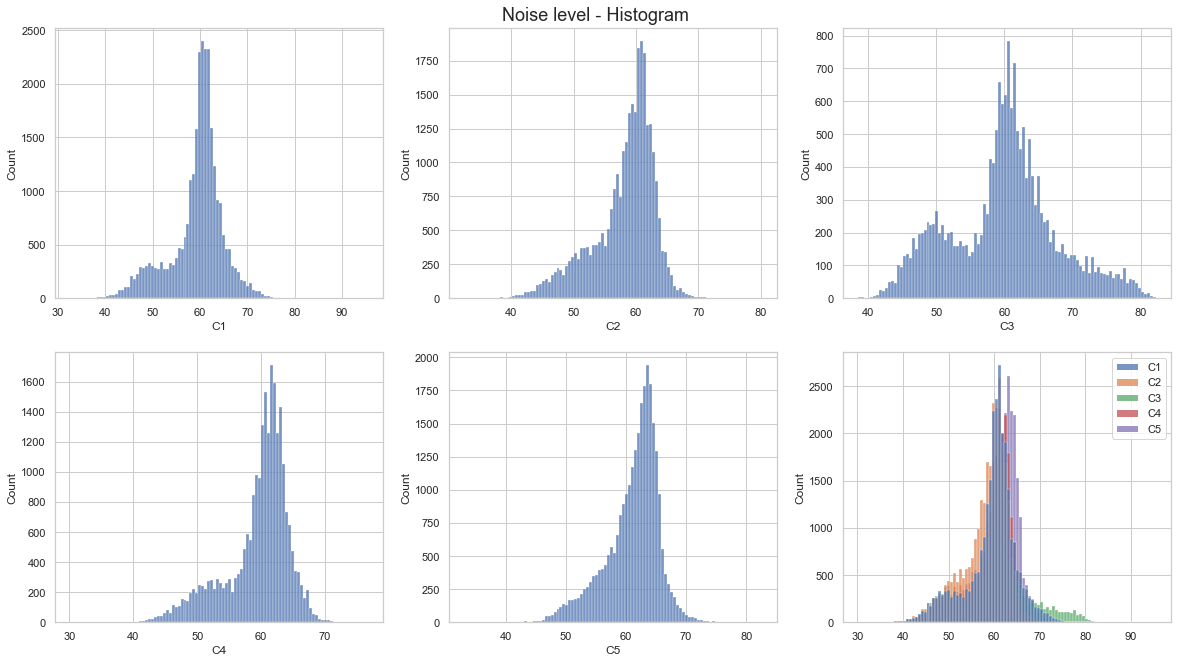

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
m = 'stack'
fd = {'fontsize': 16}
fd_l = {'fontsize': 12}

axis = [axs[0, 0], axs[0, 1], axs[0, 2], axs[1, 0], axs[1, 1], axs[1, 2]]

for i in range(6):    
    if i==5:
        sns.histplot(df[sensors], ax=axis[i],bins=100, multiple=m)
    else:
        sns.histplot(df[sensors[i]], ax=axis[i], bins=100, multiple=m)

fig.suptitle("Noise level - Histogram", size=18)
fig.subplots_adjust(top=0.95)

The represented histograms for each one of the sensors, and the last one for all, allow us to verify that the distribution of sound levels is similar between sensors, with a region that stands out from the rest. Even so, the region with the highest counts for C1, C2, and C3 is centered approximately at 60 dB, while for C4 and C5 it is centered at 64 dB.

For C1, C3 and C4 there is yet another region with an increase in counts around 50 dB, followed by a decrease in 55 dB.

It should be noted that C3 is the sensor with more values in the 80 dB region, which may indicate that it is located in an area with higher peaks of noise levels.

## Plotting Data

Text(0.5, 0.9, 'Noise Level')

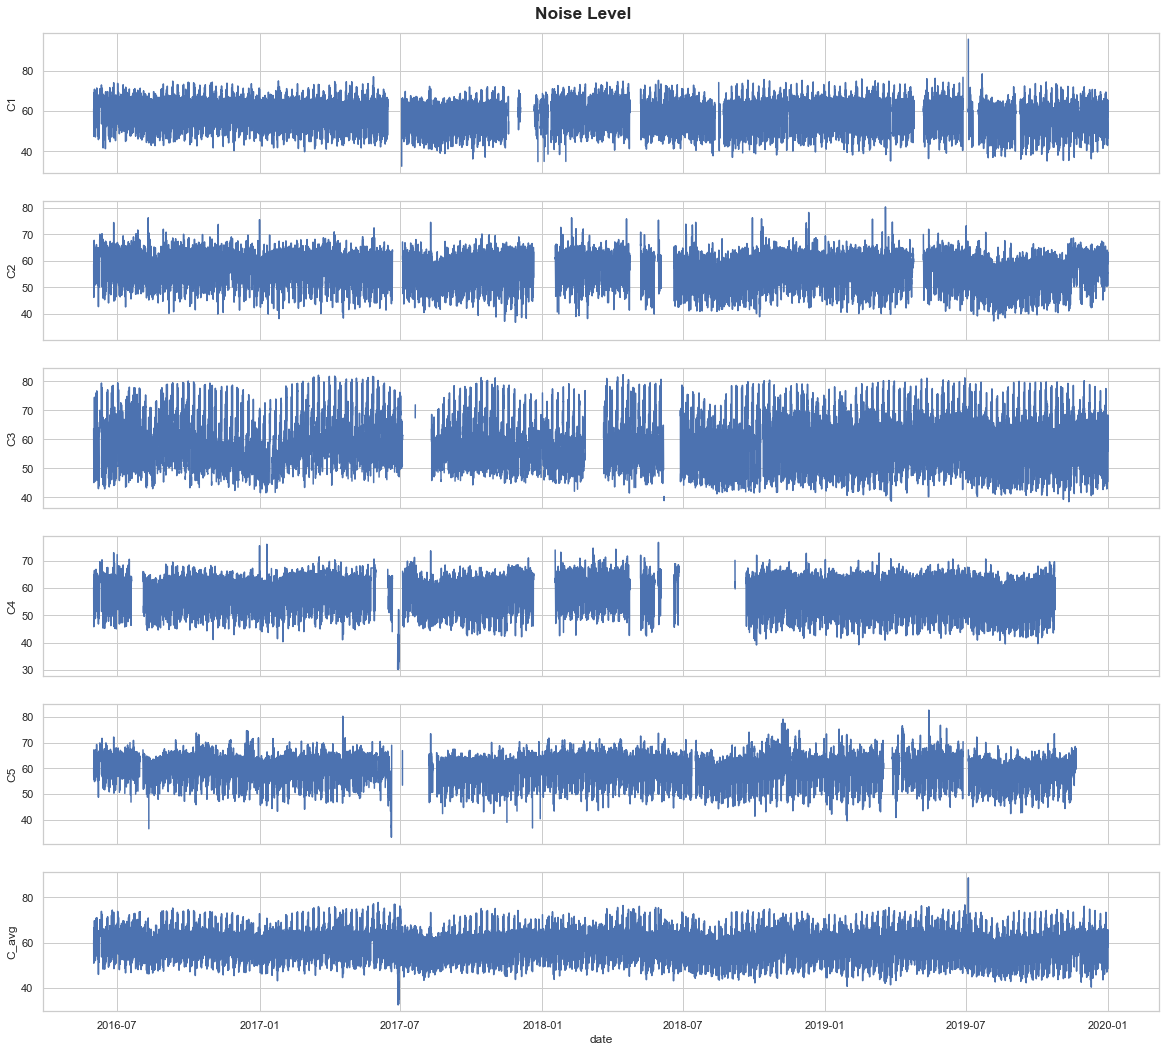

In [9]:
fig, axs = plt.subplots(6, 1, sharex=True, figsize=(20, 18))
sns.lineplot(data=df.C1, ax=axs[0])
sns.lineplot(data=df.C2, ax=axs[1])
sns.lineplot(data=df.C3, ax=axs[2])
sns.lineplot(data=df.C4, ax=axs[3])
sns.lineplot(data=df.C5, ax=axs[4])
sns.lineplot(data=df.C_avg, ax=axs[5])

fig.suptitle("Noise Level", fontsize='x-large', fontweight='bold', y=.9)

In [10]:
last_date_c4 = df['C4'].dropna().tail(1).index.values
print("C4 - Last date with value: " + str(last_date_c4))
last_date_c5 = df['C5'].dropna().tail(1).index.values
print("C5 - Last date with value: " + str(last_date_c5))

C4 - Last date with value: ['2019-10-24T17:00:00.000000000']
C5 - Last date with value: ['2019-11-20T08:00:00.000000000']


The above figures represent the evolution of noise level for each sensor over time. For all sensors, there are periods in which are not recorded values.

For C4 and C5 sensors, it is verified that their acquisition ends before the end of 2019, ending for C4 in October 2019 and for C5 in November 2019.

For C_avg there is no period without monitoring, which means that every day at least one of the sensors monitored the sound levels.



**para C4 parece haver mais periodo de falha do C3, porque é que C3 tem mais NaN values?**

# Exploratory Data Analysis

## Correlation between sensors

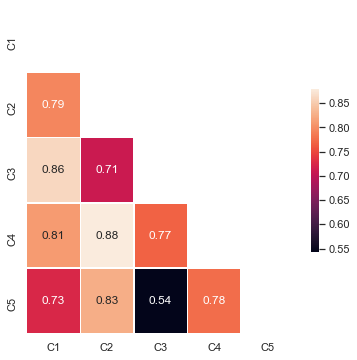

In [11]:
correlation_matrix(df[sensors], (6,6))

Through the correlation between sensors, it is already possible to verify that there are highly correlated sensors.

Starting with sensor C1, the sensor it correlates most with is sensor C3, and vice versa. When inspecting the location of each of these sensors, it was found that geographically they are very close, which justifies the high correlation between them.

Another very notable correlation is between C4 and C2. Again, when observing the location of each one, it was verified highest proximity between them and is why they are so correlated.

Sensor C5 is the one that least relates to the rest but still has a high correlation with C2 and C4 **Bruno Gráfico**

Overall, all sensors are highly correlated and one explanation for this is that, despite being grouped, they are located a few blocks from each other and in addition they can all be placed near areas with the same type of movement, justifying the correlation.

## Autocorrelation Plot

Autocorrelation compares the time series with itself (at different time points) in order to find the lags that are more correlated with each other. [8]

Note that the way the lags are compared is by shifting the time series. As time goes by, there are fewer values to compare, and, therefore, the correlation value is expected to decrease over time.

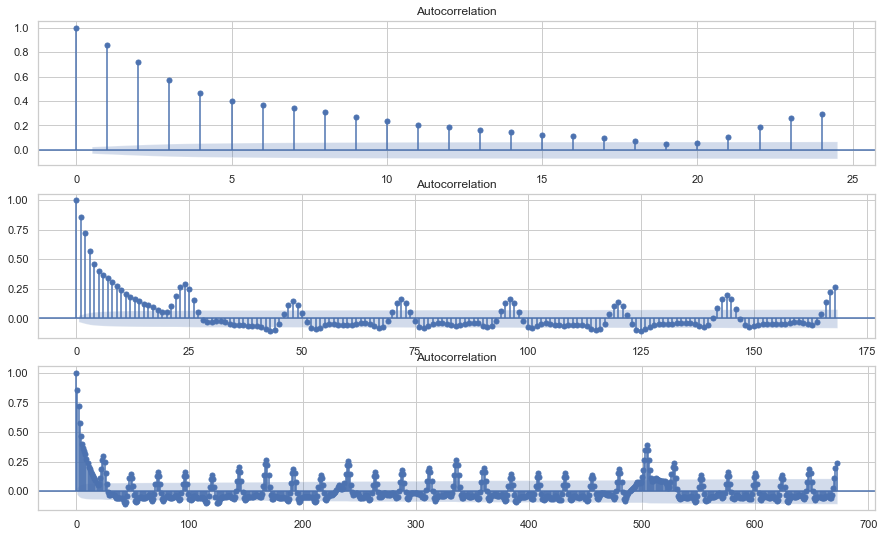

In [12]:
def autocorrelation(df, ps):
    
    df = df.fillna(0)
    
    fig, ax = plt.subplots(len(ps), 1, figsize=(15, 3*len(ps)))
    for i in range(len(ps)):
        plot_acf(df.tolist(), lags=ps[i], ax=ax[i])
        
autocorrelation(df[(df.year==2016)].C1, [24, 24*7, 24*7*4])

The above figure represents the different autocorralation analysis for the year of 2016.

It is analyzed that:
- in the first plot, we have the first 24 lags (1 day). The autocorrelation value goes down and then starts to increase reaching the maximum in 24h.
- in the second plot, we see that this pattern repeats itself again, and we have the maximums in multiples of 24 (after one day, two days...).
- in the 3rd plot, we see that this pattern is repeated throughout the month, and it is possible to observe higher peaks corresponding to the lags of each week.

                                                24*7 = 168
                                                24*14 = 336
                                                24*21 = 504
**Conclusão** 

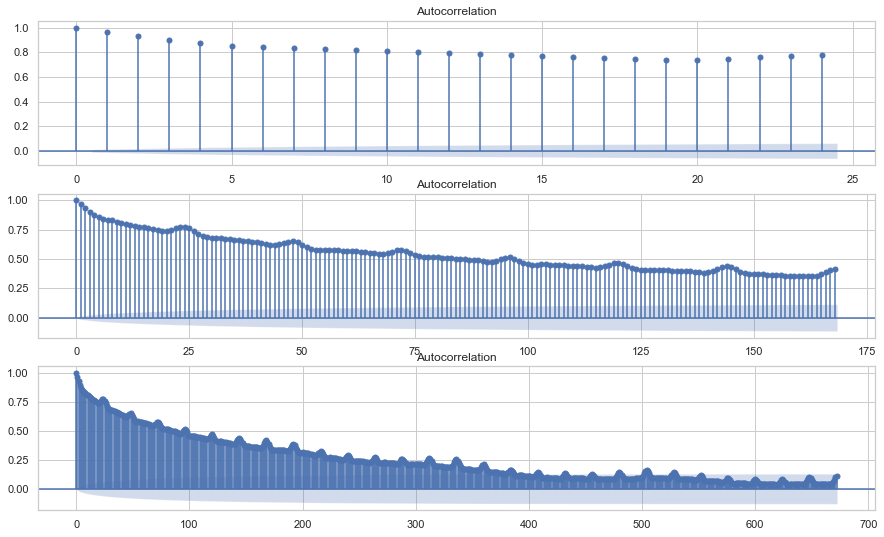

In [13]:
autocorrelation(df.C1, [24, 24*7, 24*7*4])

In this figure, the autocorrelation analysis is for all years (2016-2019) and although it is less noticeable as in the previous figure because there is more data, the verified patterns are present.

## Seasonal decompose

Given the presence of zeros, the additive decomposition is performed instead of the multiplicative. This decomposition divides data into three componentes: trend, seasonal and resid.

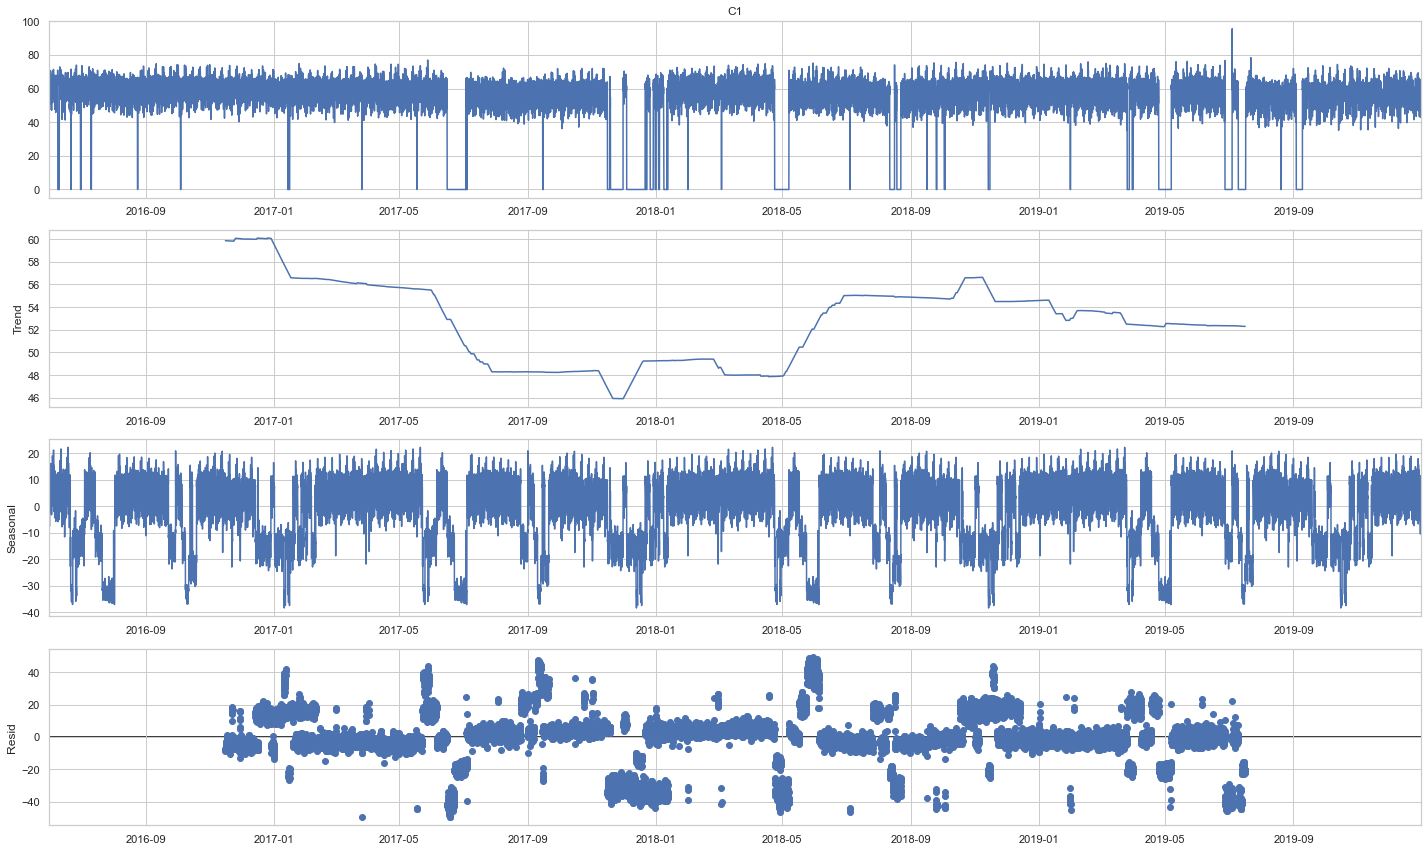

In [14]:
def ts_seasonal_decompose(df, ps):
    
    df = df.fillna(0)

    for p in ps:
        decomposition = seasonal_decompose(df, model='additive', period=p)
        decomposition.plot()
        
ts_seasonal_decompose(df.C1, [24*7*4*12]) # 24*7*4*12 -> vai considerar os padrões anuais dos dados

Ao analisarmos os dados todos para o sensor 1 conseguimos visualizar a existencia de padrões sasonais (diários, semanis, mensais e anuais) capturados pela trend component. 

A trend diminui e depois volta a aumentar, no entanto isto pode dever-se ao facto de terem aumentado as falhas do sensor.

***Considerar métodos de smoothing ou interpolação???***

Se nos focarmos apenas num ano de dados, obtemos o seguinte:

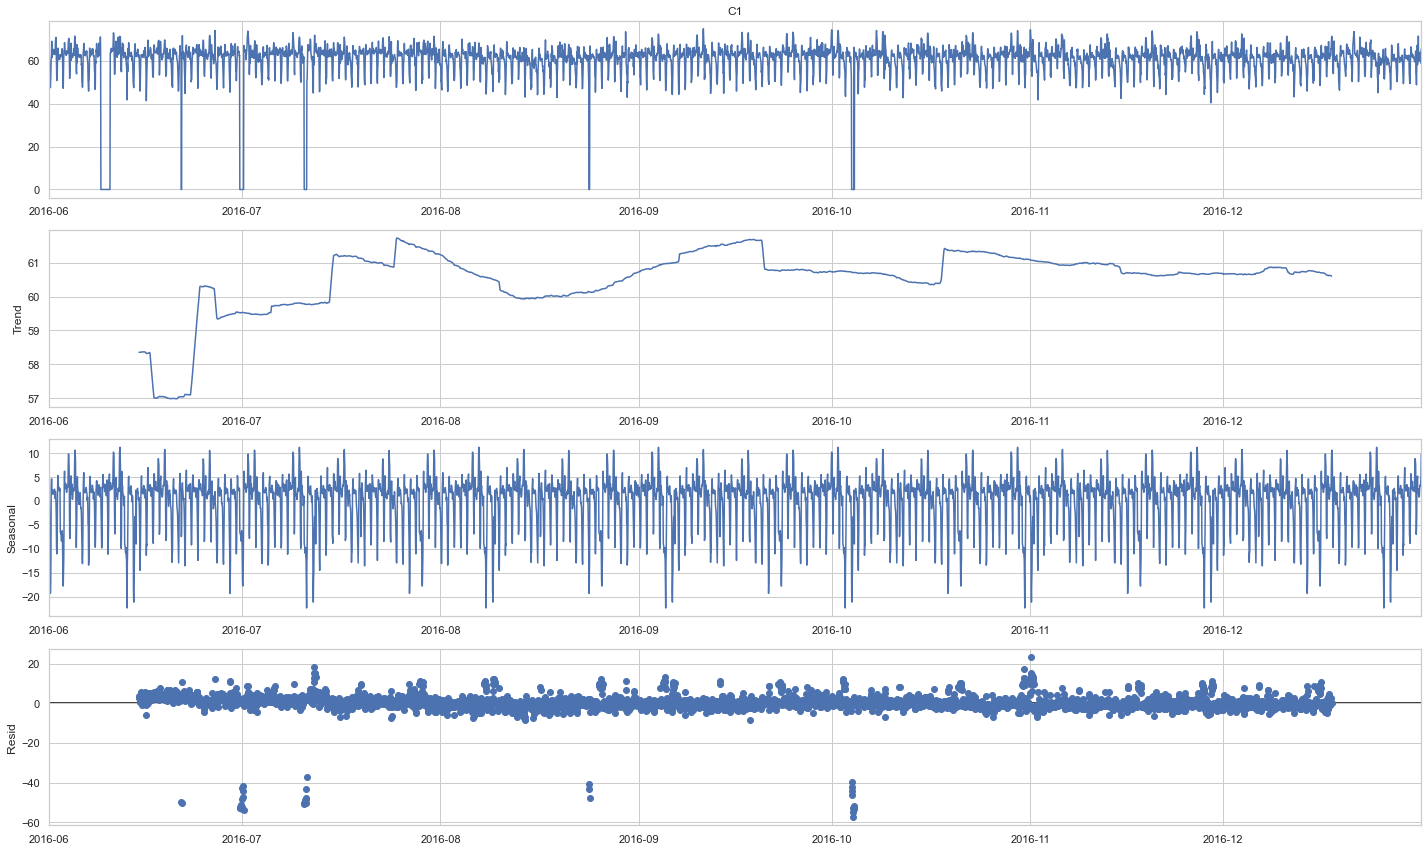

In [15]:
ts_seasonal_decompose(df[df.year==2016].C1, [24*7*4])

Ao considerar apenas o no de 2016 é mais perceptível a existência de padrões. Regra geral existe um tendencia crescente.

## Moving Average

<AxesSubplot:xlabel='date'>

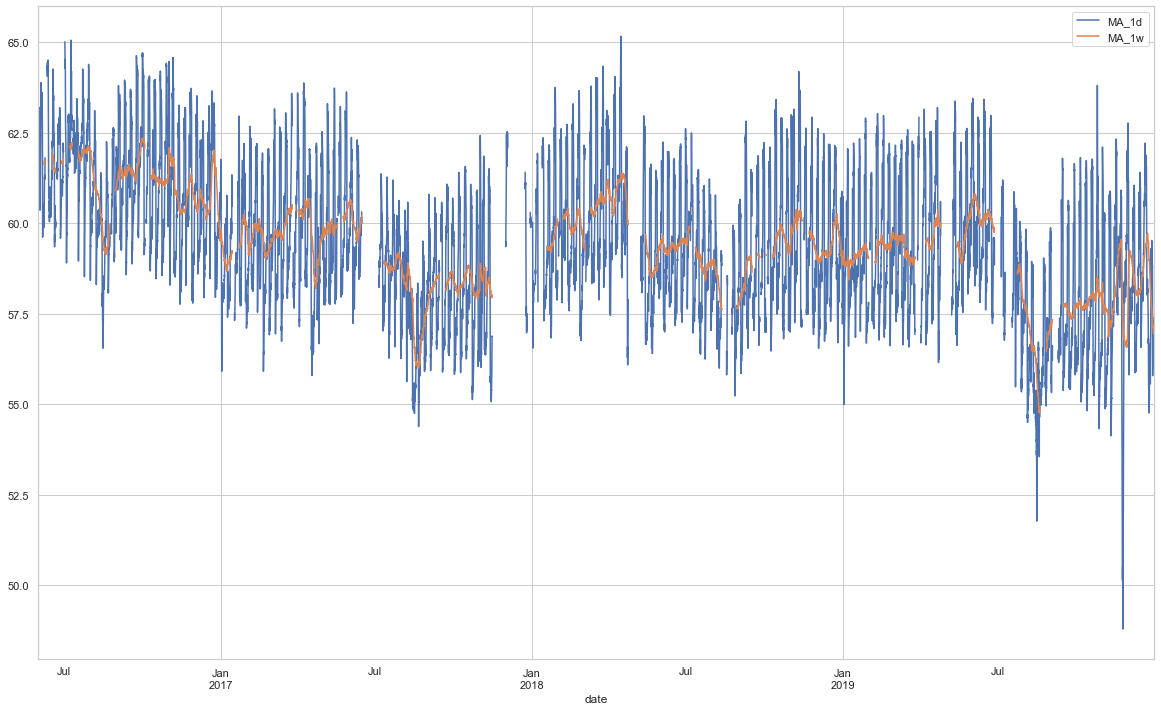

In [16]:
df['MA_1d'] = df['C1'].rolling(window=24).mean()
df['MA_1w'] = df['C1'].rolling(window=24*7).mean()

df[['MA_1d', 'MA_1w']].plot()

## External Data

### "SIM data"

In [17]:
# Opening SIM counts
janudf = pd.read_csv(base_carol+'/'+"SIM_count_15_210118.csv", sep=";") # january
marchdf = pd.read_csv(base_carol+'/'+"SIM_count_19_250318.csv", sep=";") # march
junedf = pd.read_csv(base_carol+'/'+"SIM_count_04_100618.csv", sep=";") #junedf

# SIM counts for 2018
peopledf = pd.concat([janudf, marchdf, junedf]).reset_index().drop(columns='index')
peopledf['data_da'] = pd.to_datetime(peopledf['data_da'], format='%Y-%m-%d %H:%M:%S.%f')
peopledf['Hour'] = peopledf['data_da'].dt.hour
peopledf['Date'] = peopledf['data_da'].dt.date
peopledf['Month'] = peopledf['data_da'].dt.month

In [18]:
# Noise level for 2018
noisedf = df.copy().reset_index()
noisedf['Date'] = noisedf['date'].dt.date
noisedf = noisedf.rename(columns={'hour':'Hour','month':'Month'})

#### Number of People per demographic characteristics

In [19]:
NPdf = pd.merge(noisedf, peopledf, on=['Date','Month','Hour'])
NPdf = NPdf[['Date','Month','Hour','C_avg','cluster','numero_presenze']].rename(columns={'cluster':'Demo_of_people',
                                                                             'numero_presenze':'Number_of_people'})

In [20]:
NP_D = NPdf[['Demo_of_people','Number_of_people']].groupby(['Demo_of_people']).sum().reset_index()
NP_D.sort_values('Number_of_people', ascending=False).head(10)

,Demo_of_people,Number_of_people
12,Presenze,1674986
9,Italiani,1608453
7,Consumer,1411502
13,Residenti,991967
10,Maschi,900479
8,Femmine,774506
5,>60 anni,510412
0,18-30 anni,342978
16,Visitatori Intraregionali,315489
3,51-60 anni,302091


According to the description of demographic variables and relationships between them, provided in the challenge description, some variables were discard from this analysis because represent repeated information. The variables: Presenze (P), Italiani (NI) and Consumer (TC), depend on other variables so the following analysis won't consider them.

<AxesSubplot:xlabel='Demo_of_people', ylabel='Number_of_people'>

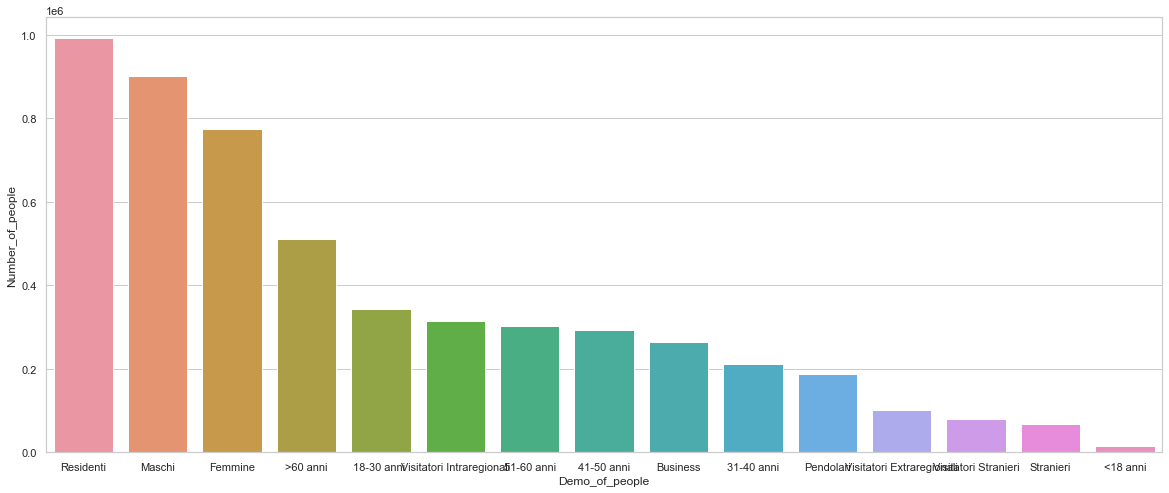

In [21]:
NP_D = NP_D[(NP_D['Demo_of_people'] != 'Presenze') & 
            (NP_D['Demo_of_people'] != 'Italiani') & (NP_D['Demo_of_people'] != 'Consumer')].sort_values('Number_of_people',
                                                                                                        ascending=False)
fig, axs = plt.subplots(figsize=(20,8))
sns.barplot(x='Demo_of_people', y='Number_of_people', data=NP_D)

Regarding age groups, the one with the highest number of people in the area is the >60 years old group, followed by the 18-30, the 51-60, and the 41-50 years old groups.

As for gender, the male gender has the greater number of people but the difference for the female is not very significant.

Another analysis is regarding the type of visitors: resident (Residenti), commuter (Pendolari), foreigner (Stranieri), extra-regional (Extraregionali), or intra-regional (Intraregionali). The type of visitors with the highest number of people is the resident, as expected, and the second is the intra-regional visitors, with a considerable difference of around 700,000 people. Then, come the commuters, the extra-regional visitors, and foreigners.

#### Noise pollution vs Number of People

In [22]:
N_NP = NPdf[['C_avg','Number_of_people']].groupby(['C_avg']).mean().reset_index() # mean number of people per day and hour

<AxesSubplot:xlabel='Number_of_people', ylabel='C_avg'>

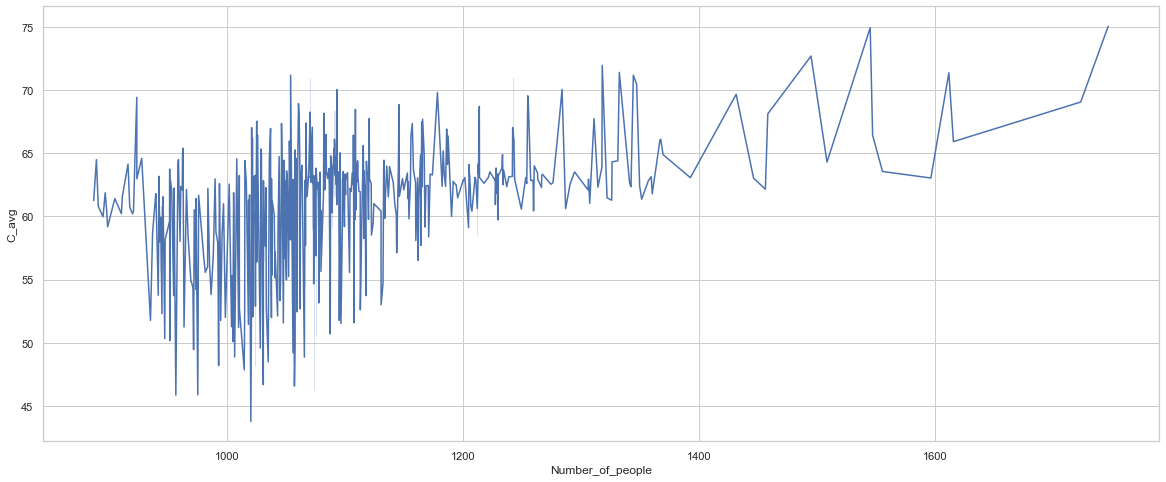

In [23]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(data=N_NP, x="Number_of_people", y="C_avg", ax=ax)

In the first graph, in which the number of people per day and hour is represented with the level of noise pollution in (dB), it can be noticed that the higher the number of people, the higher the noise levels. From 65dB, are detected higher peaks in the number of people and, from 73dB, it is when the number of people is the highest.

#### Noise vs Demographic Characteristics

In [24]:
N_D = NPdf.copy()
N_D = N_D[(N_D['Demo_of_people'] != 'Presenze') & 
            (N_D['Demo_of_people'] != 'Italiani') & (N_D['Demo_of_people'] != 'Consumer')]

In [25]:
def noise_groups (df, mini, maxi):
    ND = df[(df['C_avg']<maxi) & (df['C_avg']>=mini)]
    ND = ND[['Demo_of_people','Number_of_people']].groupby(['Demo_of_people']).mean().reset_index() # mean number of people 
                                                                                                    #per day and hour    
    total = ND[ND['Demo_of_people']=='Visitatori Intraregionali'].iloc[0,1] +\
            ND[ND['Demo_of_people']=='Visitatori Extraregionali'].iloc[0,1] +\
            ND[ND['Demo_of_people']=='Pendolari'].iloc[0,1] +\
            ND[ND['Demo_of_people']=='Visitatori Stranieri'].iloc[0,1]
    
    ND = ND.append({'Demo_of_people':'Total Visitors','Number_of_people':total},ignore_index=True)
    ND = ND.sort_values('Number_of_people', ascending=False)
    
    return ND

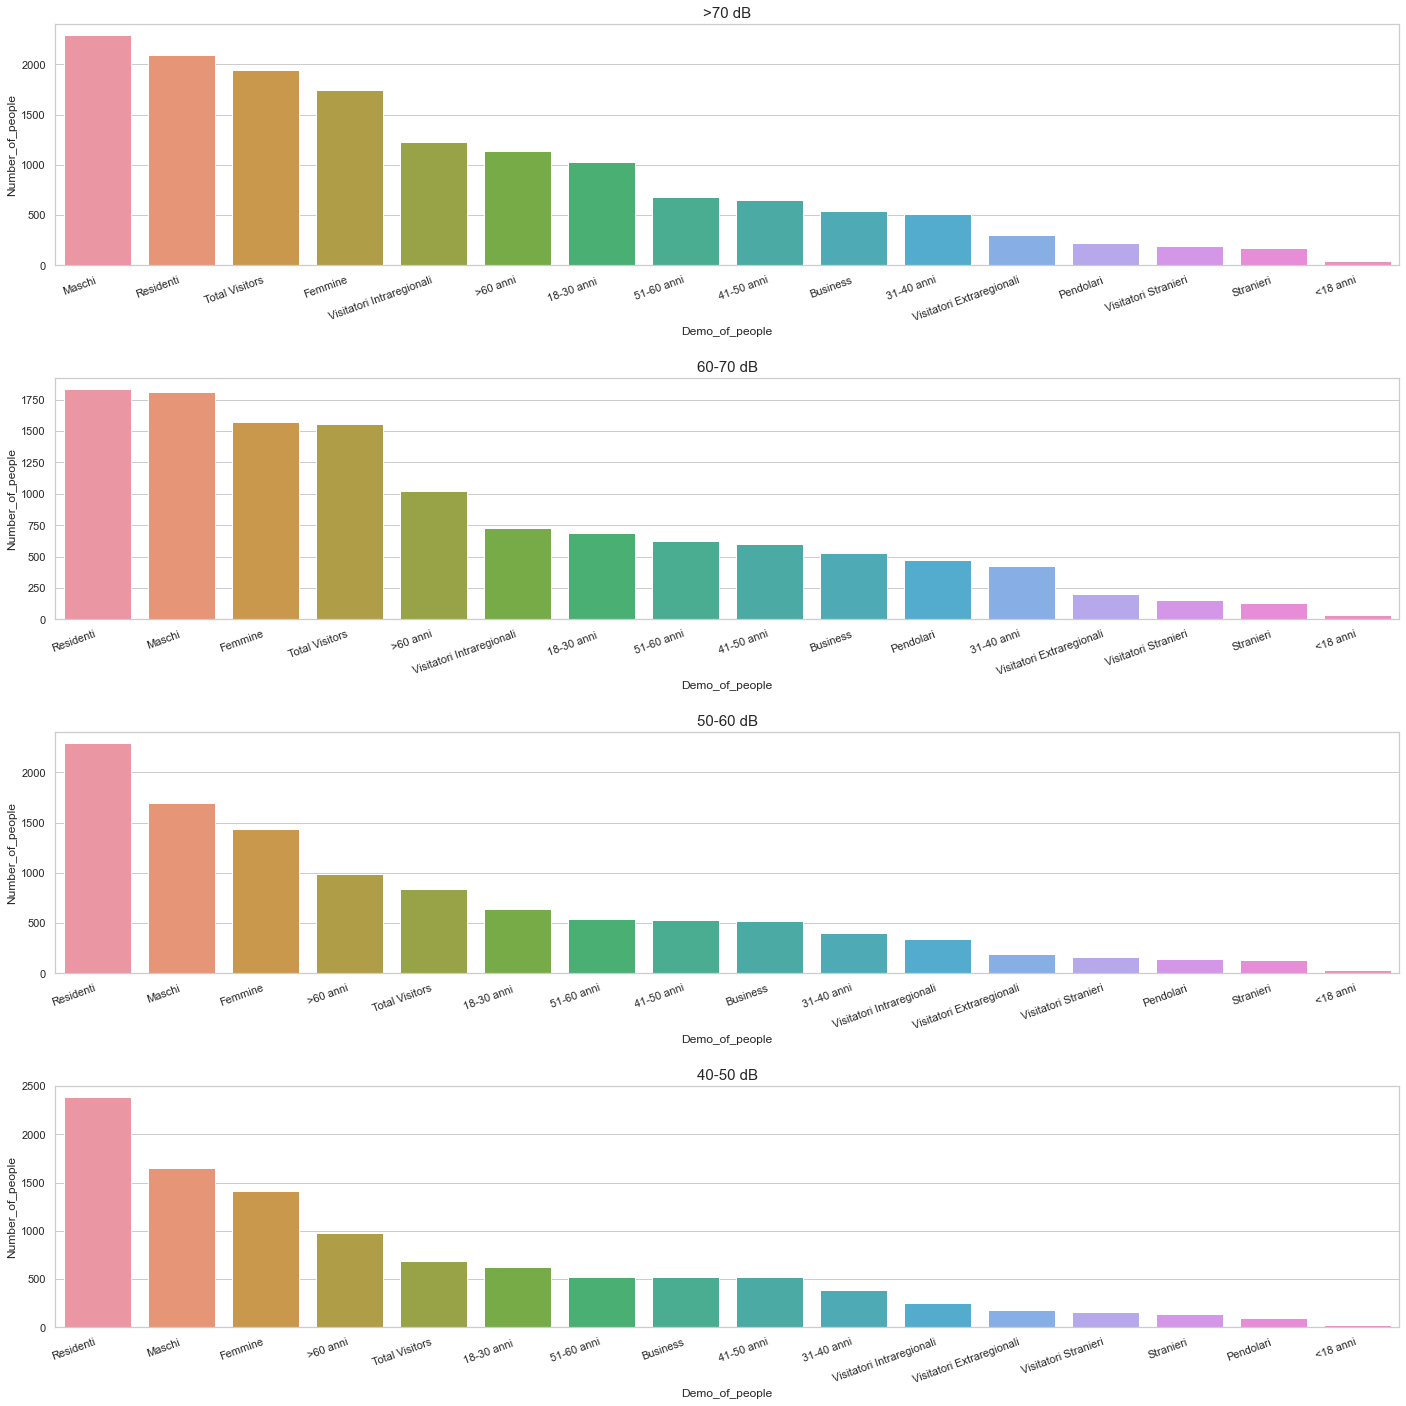

In [26]:
fig, ax = plt.subplots(4,1,figsize=(20,20))
axes = ax.ravel()

# >70 dB
ND_70 = noise_groups (N_D, 70, 80) 
sns.barplot(x='Demo_of_people', y='Number_of_people', data=ND_70, ax=axes[0])
ax[0].set_title('>70 dB', fontsize=15)
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=20, ha='right')

# 60-70 dB
ND_60 = noise_groups (N_D, 60, 70)
sns.barplot(x='Demo_of_people', y='Number_of_people', data=ND_60, ax=axes[1])
ax[1].set_title('60-70 dB', fontsize=15)
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=20, ha='right')

# 50-60 dB
ND_50 = noise_groups (N_D, 50, 60)
sns.barplot(x='Demo_of_people', y='Number_of_people', data=ND_50, ax=axes[2])
ax[2].set_title('50-60 dB', fontsize=15)
axes[2].set_xticklabels(axes[2].get_xticklabels(),rotation=20, ha='right')

# 40-50 dB
ND_40 = noise_groups (N_D, 40, 50)
sns.barplot(x='Demo_of_people', y='Number_of_people', data=ND_40, ax=axes[3])
ax[3].set_title('40-50 dB', fontsize=15)
axes[3].set_xticklabels(axes[3].get_xticklabels(),rotation=20, ha='right')

fig.tight_layout(pad=2.0)

ANÁLISE: (género, idade, visitantes) **Arranjar texto**
    
    - quando se verificam niveis máximo de dB existe um aumento de número de género masculino face ao feminino e ainda o máximo passar para o género masculino em vez de ser os residents
    
    - quanto às idades: com o aumento do dB verifica-se um aumento na população dos 18-30 de tal forma que para 40-50 dB, a diferença entre >60 e 18-30 é de 500 dB e para >70 de 200 dB. Estas dois age groups são seguidos pelos 51-60, 41-50 e só depois 31-40
    
    - visitantes: residents são sempre o grupo de visitors com maior número de pessoas para cada nível de dB. Verifica-se que visitor intraregional é sempre o segundo contudo há um claro aumento no número de pessoas para os níveis mais altos. Por exemplo 40-50 a diferença entre residents e visitor intra é de 2000 pessoas e para >70 é apenas 1000 pessoas.
    
**ainda tenho a dúvida do business e qual diferença entre stranieri e visitor stranieri**

Conclusões:
- níveis máximo de dB relacionados com um aumento do género masculino, aumento dos 18-30 e aumento de visitor intraregionali.

<AxesSubplot:xlabel='Number_of_people', ylabel='C_avg'>

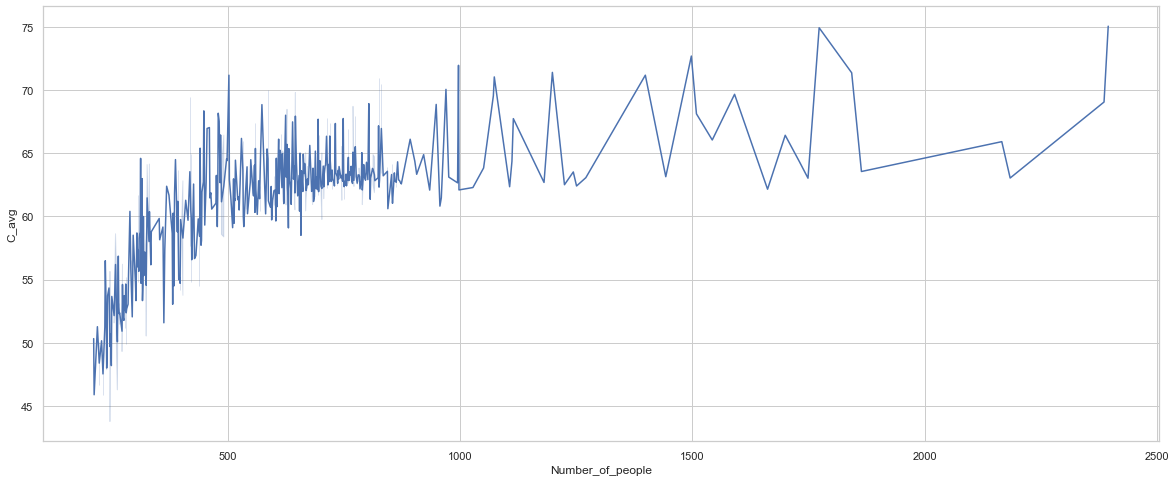

In [27]:
# Visitatori Intraregionali
N_D_visi = N_D[N_D['Demo_of_people']=='Visitatori Intraregionali']
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(data=N_D_visi, x="Number_of_people", y="C_avg", ax=ax)

<AxesSubplot:xlabel='Number_of_people', ylabel='C_avg'>

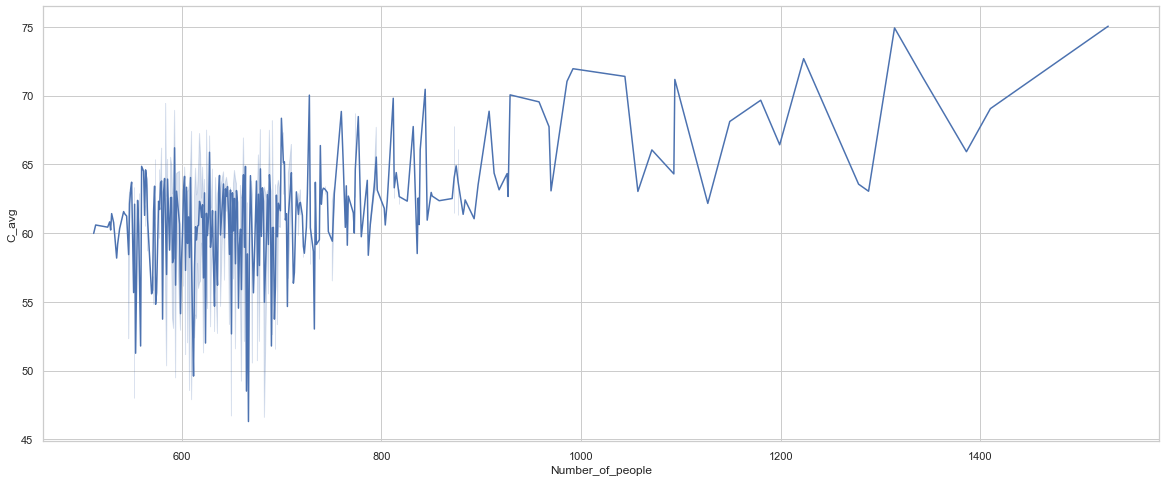

In [28]:
# Visitatori Intraregionali
N_D_18 = N_D[N_D['Demo_of_people']=='18-30 anni ']
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(data=N_D_18, x="Number_of_people", y="C_avg", ax=ax)

<AxesSubplot:xlabel='Number_of_people', ylabel='C_avg'>

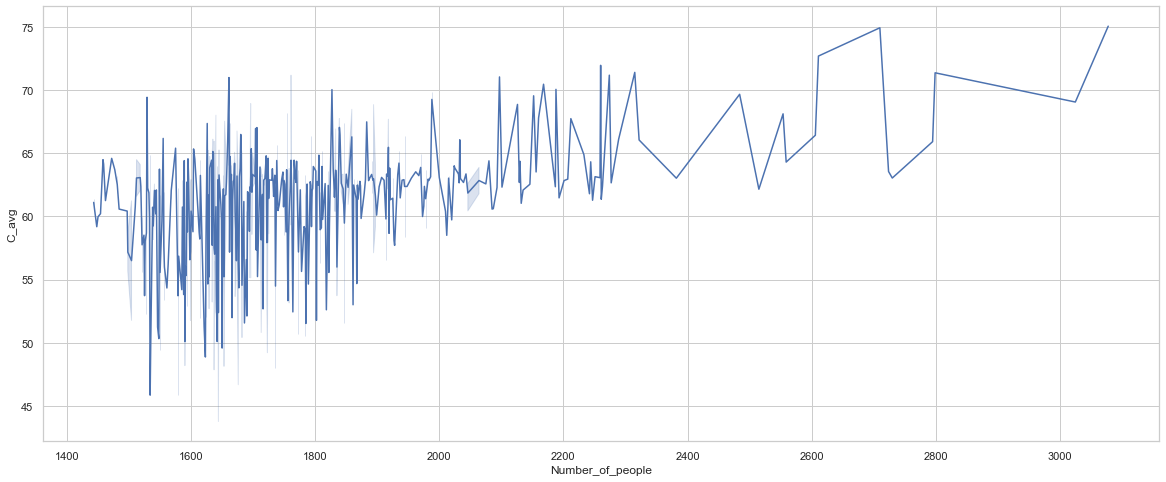

In [29]:
# Visitatori Intraregionali
N_D_M = N_D[N_D['Demo_of_people']=='Maschi']
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(data=N_D_M, x="Number_of_people", y="C_avg", ax=ax)

##### Demographic analysis for the day and time with the maximum and minimum level of noise pollution

In [30]:
print('Maximum Noise Level')
print(N_D.sort_values('C_avg', ascending=False).head(1))
print('\nMinimum Noise Level')
print(N_D.sort_values('C_avg', ascending=True).head(1))

Maximum Noise Level
            Date  Month  Hour      C_avg             Demo_of_people  \
5630  2018-03-24      3    23  75.047813  Visitatori Extraregionali   

      Number_of_people  
5630               412  

Minimum Noise Level
           Date  Month  Hour      C_avg Demo_of_people  Number_of_people
505  2018-01-16      1     3  43.784055         Maschi              1644


In [31]:
NPdf_maxdayhour = N_D[(N_D['Date']==datetime.date(2018, 3, 24)) & (N_D['Hour']==23)]
NPdf_maxdayhour = NPdf_maxdayhour.sort_values('Number_of_people', ascending=False)

NPdf_mindayhour = N_D[(N_D['Date']==datetime.date(2018, 1, 16)) & (N_D['Hour']==3)]
NPdf_mindayhour = NPdf_mindayhour.sort_values('Number_of_people', ascending=False)

Text(0.5, 1.0, 'Minimum Noise Pollution')

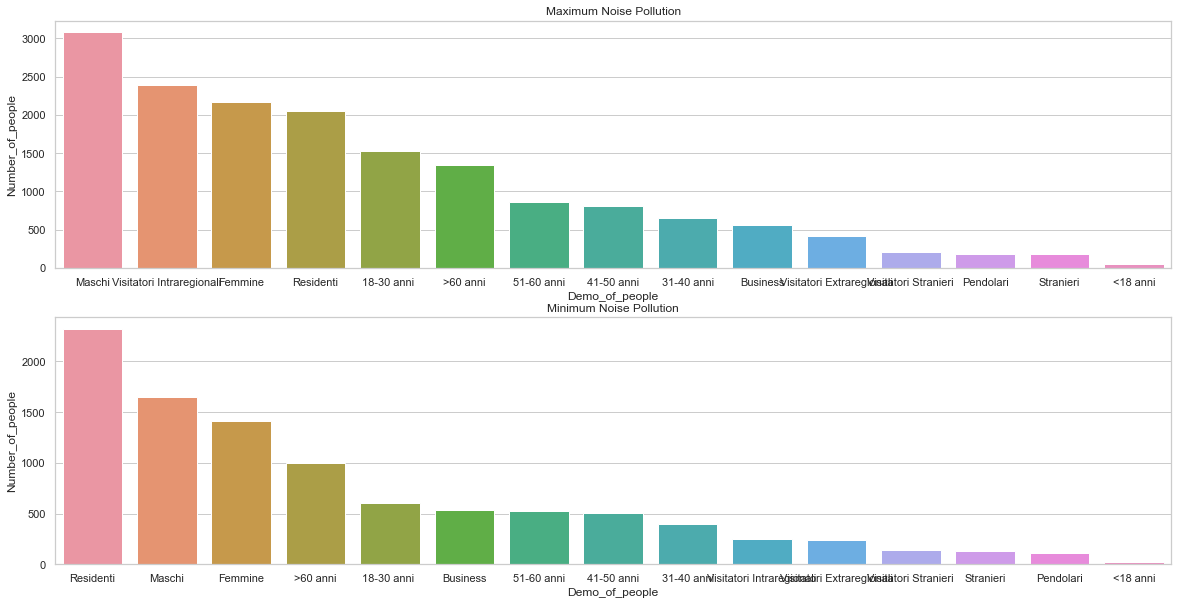

In [32]:
fig, ax = plt.subplots(2,1,figsize=(20,10))
ax = ax.ravel()
# Maximum
sns.barplot(x='Demo_of_people', y='Number_of_people', data=NPdf_maxdayhour, ax=ax[0])
ax[0].set_title('Maximum Noise Pollution')

# Minimum
sns.barplot(x='Demo_of_people', y='Number_of_people', data=NPdf_mindayhour, ax=ax[1])
ax[1].set_title('Minimum Noise Pollution')

# Outlier Detection 

0 ou 1 se há ou não outlier

## Using Z-Score for excessive noise detection

In [43]:
def outlier_detection_using_z_score(df, t=1, sensor='C1'):
    # t - threshold - number of standard deviation
    mean = np.mean(df.iloc[:, 0])
    std = np.std(df.iloc[:, 0])
 
    # não fazemos abs((i-mean)/std) porque só nos interessa os que estão acima da média
    df['z_score'] = [(i-mean)/std for i in df.iloc[:, 0]]
    df['is_outlier'] = [1 if x>t else 0 for x in df.z_score.values ]
 
    df['out'] = df[sensor] * df['is_outlier']
    df['out'] = [None if x==0 else x for x in df.out.values]
 
    df = df.reset_index()
 
    return df
 
df_out = outlier_detection_using_z_score(df[['C1']],1)
df_out
 
def get_avg_number_outliers(df, sensors):
 
    l_c_out = []
 
    for sensor in sensors:
        c_out = outlier_detection_using_z_score(df[[sensor]], 1, sensor).set_index('date')[['is_outlier']]
        c_out = c_out.rename(columns={'is_outlier': sensor + '_is_outlier'})
        l_c_out.append(c_out)
 
    df_tot = pd.concat(l_c_out, axis=1)
    df_tot = df_tot.resample('1D').sum()
    df_tot['mean_is_outlier'] = df_tot.mean(axis = 1)
 
    return df_tot


df_outliers_avg = get_avg_number_outliers(df, sensors)
df_outliers_avg

,C1_is_outlier,C2_is_outlier,C3_is_outlier,C4_is_outlier,C5_is_outlier,mean_is_outlier
date,,,,,,
2016-06-01,3,10,1,2,6,4.4
2016-06-02,3,1,4,2,1,2.2
2016-06-03,4,4,3,1,2,2.8
2016-06-04,8,5,5,4,4,5.2
2016-06-05,5,1,4,4,0,2.8
...,...,...,...,...,...,...
2019-12-27,1,0,1,0,0,0.4
2019-12-28,2,2,4,0,0,1.6
2019-12-29,3,0,4,0,0,1.4


In [44]:
print("Number of outliers detected: " + str(df_out['is_outlier'].sum()))

Number of outliers detected: 2971


## Visualizing the excessive noise detected

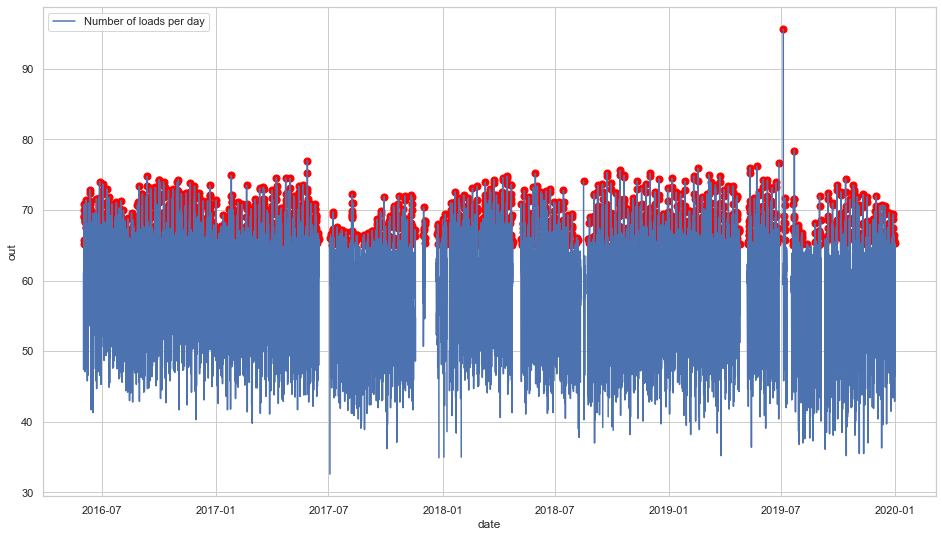

In [45]:
def plot_outliers(df):
    fig, ax = plt.subplots(figsize=fig_dim)

    sns.lineplot(data=df, x='date', y='C1', ax=ax, label="Number of loads per day")
    sns.regplot(data=df, x='date', y="out", fit_reg=False, 
                scatter_kws={"color":"red","alpha":1,"s":50}, ax=ax, label='Holidays')
    
plot_outliers(df_out)

## Maximum noise outliers vs Number of visitors intraregional using SIM data

In [46]:
df_outliers_avg.head()

,C1_is_outlier,C2_is_outlier,C3_is_outlier,C4_is_outlier,C5_is_outlier,mean_is_outlier
date,,,,,,
2016-06-01,3,10,1,2,6,4.4
2016-06-02,3,1,4,2,1,2.2
2016-06-03,4,4,3,1,2,2.8
2016-06-04,8,5,5,4,4,5.2
2016-06-05,5,1,4,4,0,2.8


In [47]:
N_D

,Date,Month,Hour,C_avg,Demo_of_people,Number_of_people
1,2018-01-14,1,23,58.758641,Maschi,1613
2,2018-01-14,1,23,58.758641,Femmine,1358
3,2018-01-14,1,23,58.758641,Business,495
6,2018-01-14,1,23,58.758641,Stranieri,122
7,2018-01-14,1,23,58.758641,<18 anni,25
...,...,...,...,...,...,...
9049,2018-06-10,6,21,60.932660,Visitatori Intraregionali,644
9050,2018-06-10,6,21,60.932660,Visitatori Extraregionali,153
9051,2018-06-10,6,21,60.932660,Pendolari,94
9052,2018-06-10,6,21,60.932660,Residenti,2181


In [48]:
N_D_visi = N_D[N_D['Demo_of_people']=='Visitatori Intraregionali']

In [49]:
visi = N_D_visi[['Date','C_avg','Number_of_people']].groupby('Date').mean().reset_index()

In [57]:
df_outliers_avg = df_outliers_avg.reset_index()
df_out = df_outliers_avg.rename(columns={"date": "Date"})
visi['Date'] = pd.to_datetime(visi['Date'])

In [58]:
df_ = pd.merge(visi, df_outliers_avg, on='Date')

KeyError: 'Date'

In [ ]:
df_

In [ ]:
# Visitatori Intraregionali
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(data=df_, x="Number_of_people", y="mean_is_outlier", ax=ax)

# Predict future noise levels

## ARIMA

In [ ]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

lags = 24

def forecasting_with_sarimax(train, test, order, seasonal_order, lags):
    mod = sm.tsa.statespace.SARIMAX(train, order=order, seasonal_order=seasonal_order, simple_differencing=True)
    res = mod.fit()
    
    predictions = res.forecast(steps=lags)
        
    rmse = math.sqrt(mean_squared_error(test, predictions))
    
    #print(res.summary())
    
    return res.bic, rmse, predictions

train = df['C1'][:-lags]
test = df['C1'][-lags:]

# Escolher o modelo com maior BIC
bic, rmse, predictions = forecasting_with_sarimax(train, test, (2,1,0), (1,1,0,12), lags)
print(bic, rmse)

# Medidas de combate ao barulho

- meter a polícia a fazer patrulhas/organização
- meter capacidades máximas de pessoas em locais

# Conclusions

## Scalability and Impact

## Future Work

# References

[1]	W. Davies, P. Hepworth, A. Moorhouse, and R. Oldfield, “Noise from Pubs and Clubs Phase I,” Contract, no. October, 2005. Available: http://scholar.google.com/scholar?hl=en&btnG=Search&q=intitle:Noise+from+Pubs+and+Clubs+Phase+I#0.

[2]	Y. Nakane, M. Tazaki, and E. Miyaoka, “Whoqol,” Iryo To Shakai, vol. 9, no. 1, pp. 123–131, 1999, doi: 10.4091/iken1991.9.1_123.

[3]	European Environment Agency, Environmental noise in Europe - 2020, no. 22/2019. 2020.

[4]	World Health Organization, “WHO night noise guidelines for Europe.” https://www.euro.who.int/en/health-topics/environment-and-health/noise/policy/who-night-noise-guidelines-for-europe.

[5]	“Noise pollution: how to reduce the impact of an invisible threat?” https://www.iberdrola.com/environment/what-is-noise-pollution-causes-effects-solutions.

[6]	E. Gallo and L. Shtrepi, “Long term monitoring of noise pollution in social gatherings places: Time analysis and acoustic capacity as support of management strategies,” Proc. Int. Congr. Acoust., vol. 2019-Septe, no. September, pp. 333–340, 2019, doi: 10.18154/RWTH-CONV-239494.

[7]	E. Gallo, E. Ciarlo, M. Santa, E. Sposato, B. Vincent, and Y. Halbwachs, “Analysis of leisure noise levels and assessment of policies impact in San Salvario district , Torino ( Italy ), by low-cost IoT noise monitoring network,” pp. 699–704, 2018.

[8]	“Autocorrelation.” https://otexts.com/fpp2/autocorrelation.html.